# ESN example with synthetic data. Classification task

In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg

In [2]:
# text color for the plots below. Change COLOR to 'black' if you have white theme
from matplotlib import rcParams
COLOR = 'white'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

### 1. Generate synthetic data

In [3]:
data_dim = 2 # dimentionality of the data
num_samples = 500 # number of samples per class
num_classes = 3 # don't forget to change num_classes according to the number of classes in the dataset

In [4]:
# don't forget to change num_classes according to the number of classes in the dataset
np.random.seed(7)
x1 = 0.75 * np.random.standard_normal((data_dim, num_samples))
x2 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) - 4)
x3 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 4)
# x4 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 1)
# x5 = 0.3 * (np.random.standard_normal((data_dim, num_samples)) + 8)
data = np.concatenate((x1, x2, x3), axis=1)
data.shape

(2, 1500)

In [5]:
# prepare labels
Y_train = np.zeros(shape=(num_classes, num_classes * num_samples))
for i in range(num_classes):
    Y_train[i, i * num_samples:(i + 1) * num_samples] = 1
Y_train = np.transpose(Y_train)

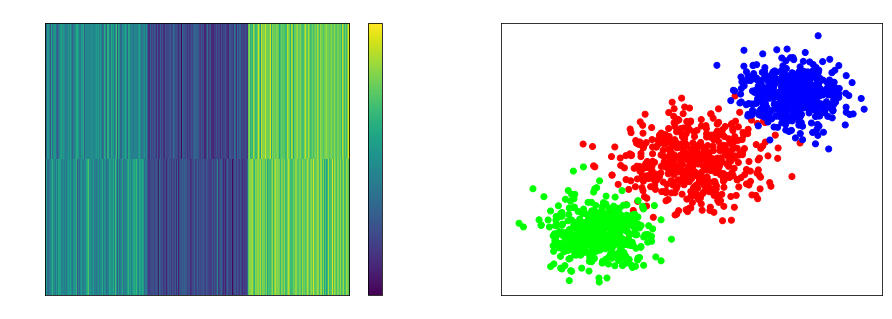

In [6]:
figure(figsize=(15,5))
subplot(1, 2, 1)
imshow(data, aspect='auto')
title("Generated synthetic data (image view)")
colorbar()

## only for 2D datasets
subplot(1, 2, 2)
title("Generated synthetic data (scatterplot view)")
scatter(data[0], data[1], c=Y_train)

#### Shuffle (optional)

In [7]:
from sklearn.utils import shuffle
data, Y_train = shuffle(data.T, Y_train)
data = data.T

### 2. Prep reservoir

The ESN implementation is based on the guidelines from [A Practical Guide to Applying Echo State Networks](https://mantas.info/get-publication/?f=Practical_ESN.pdf) by [Dr. Mantas Lukoševičius](https://mantas.info/).

In [8]:
# generate the ESN reservoir
in_size = out_size = 1
res_size = 100
a = 0.3 # leaking rate
random.seed(42)
W_in = (random.rand(res_size, 1 + in_size) - 0.5) * 1
W = random.rand(res_size, res_size) - 0.5
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...'),
rho_W = max(abs(linalg.eig(W)[0]))
print('Done!')
W *= 1.25 / rho_W

Computing spectral radius...
Done!


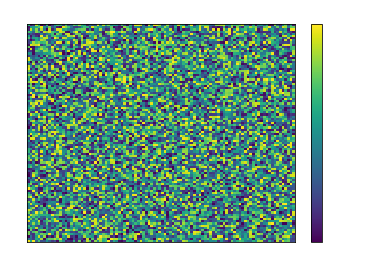

In [9]:
imshow(W, aspect='auto')
title("Reservoir adjacency matrix $\mathbf{W}$")
colorbar()

### 3. Record reservoir activations $\mathbf{x}(n)$

ESN uses an RNN type with leaky-integrated disctrete-time continuous-value units. The typical update equation is:

$\mathbf{x}(n) = (1 - \alpha)\mathbf{x}(n - 1) + \alpha \tanh (\mathbf{W}^{in}[1; \mathbf{u}(n)] + \mathbf{Wx}(n - 1))$

In [10]:
def record_reservoir_activations(data, W_in, in_size, W, init_samples = 0):
    """
    Generate and record reservoir responses to the data samples.
    
    By default, we will run the ESN in classification mode so we don't need initializaiton.
    Hence, init_samples == 0 by default. If you need to run in generative mode, change the 
    initialization accordingly.
    """
    data_dim, train_len = data.shape
    res_size = W.shape[0]
    
    # allocated memory for the design (collected states) matrix
    X = zeros((1 + in_size + res_size, train_len - init_samples))
    
    # run the reservoir with the data and collect X
    x = zeros((res_size, 1))
    for t in range(train_len):
        u = [sample[t] for sample in data] # get a data sample (a column from the data array)
        x = (1 - a) * x + a * tanh(dot(W_in, vstack((np.ones(data_dim), u))) + dot(W, x))
        if t >= init_samples:
            X[:, t - init_samples] = vstack((np.ones(data_dim), u, x))[:, 0]
    return X

In [11]:
X = record_reservoir_activations(data, W_in, in_size, W)

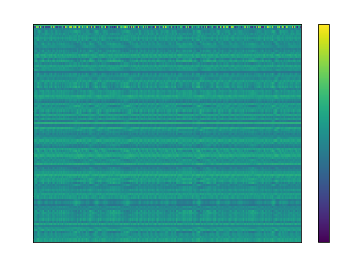

In [12]:
imshow(X, aspect='auto')
title("Reservoir activations $\mathbf{x}(n)$")
colorbar()

### 4. Train the readout $\mathbf{W}^{out}$

In [13]:
# train the output by ridge regression
reg = 1e-8  # regularization coefficient
X_T = X.T
W_out = dot(dot(Y_train.T, X_T), linalg.inv(dot(X, X_T) + reg * eye(1 + in_size + res_size)))

Text(0.5,1,'Output weights $\\mathbf{W}^{out}$')

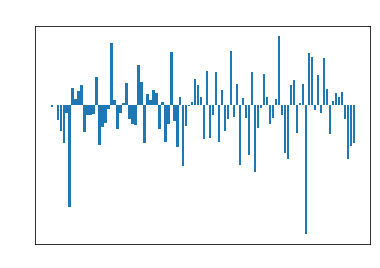

In [14]:
bar(range(1 + in_size + res_size), [v[0] for v in W_out.T])
title('Output weights $\mathbf{W}^{out}$')

### 5. Test

#### Generate test dataset

In [15]:
x1 = 0.75 * np.random.standard_normal((data_dim, num_samples))
x2 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) - 4)
x3 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 4)
# x4 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 1)
# x5 = 0.3 * (np.random.standard_normal((data_dim, num_samples)) + 8)
data_test = np.concatenate((x1, x2, x3), axis=1)
data_test.shape

(2, 1500)

In [16]:
# prepare labels
Y_test = np.zeros(shape=(num_classes, num_classes * num_samples))
for i in range(num_classes):
    Y_test[i, i * num_samples:(i + 1) * num_samples] = 1
Y_test = np.transpose(Y_test)

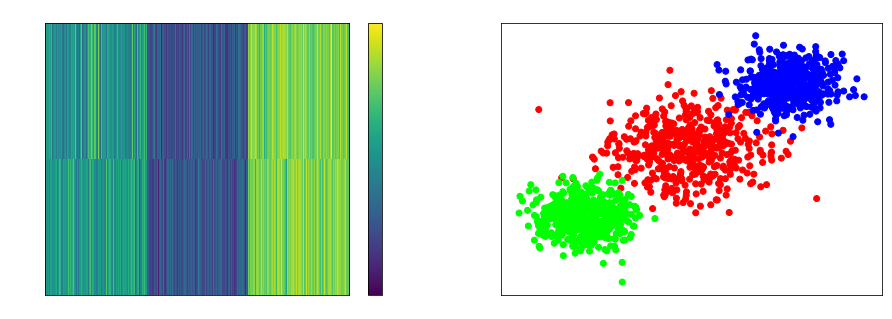

In [17]:
figure(figsize=(15,5))
subplot(1, 2, 1)
imshow(data_test, aspect='auto')
title("Generated synthetic data (image view)")
colorbar()

## only for 2D datasets
subplot(1, 2, 2)
title("Generated synthetic data (scatterplot view)")
scatter(data_test[0], data_test[1], c=Y_test)

#### Shuffle (optional)

In [18]:
data_test, Y_test = shuffle(data_test.T, Y_test)
data_test = data_test.T

#### Record reservoir activations for the test set

In [19]:
X_test = record_reservoir_activations(data_test, W_in, in_size, W)

#### Get results of testing. Compute MSE

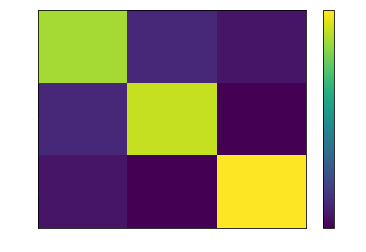

In [20]:
Y_target = dot(W_out, X_test)
imshow(dot(Y_target, Y_target.T), aspect='auto')
colorbar()

In [21]:
# compute MSE for the first errorLen time steps
errorLen = num_classes * num_samples
mse = sum(square(Y_train.T - Y_target )) / errorLen
print('MSE = ' + str(mse))

MSE = 1.2161823490477064
